# Running a Random Forest Regression Model to determine factors influencing the distribution of pCO2 in surface waters of a major Siberian River

## Outine

##### - Data Preprocessing:
##### - Construct a Random Forest model using sklearn. 
##### - Evaluate Model Performance
##### - Determine Feature Importance
##### - Interpret Results

In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis
import seaborn as sns           # Statistics and Quick Visualizations

# Data Visualization
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
from matplotlib.ticker import AutoMinorLocator # Automate the minor tick intervals on plots

import matplotlib.ticker as mticker           # advanced tick formatting and placement

# Suppress Warnings
import warnings                 # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings

# Display 
from IPython.core.display import display, HTML # Display object/HTML in a rich format
#display(HTML("<style>.container { width:100% !important; }</style>")) # increases width of cells

In [2]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler      # Standardizing features by removing the mean and scaling to unit variance
from sklearn.preprocessing import OneHotEncoder       # Encoding categorical features as a one-hot numeric array

# Model Selection and Validation
from sklearn.model_selection import train_test_split  # Splitting datasets into random train and test subsets
from sklearn.model_selection import cross_val_score   # Evaluate a score by cross-validation
from sklearn.model_selection import KFold             # K-Folds cross-validator providing train/test indices to split data

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor    # A random forest regressor.

# Pipeline
from sklearn.pipeline import make_pipeline            # Construct a Pipeline from the given estimators

# Model Evaluation Metrics
from sklearn.metrics import r2_score                  # R^2 (coefficient of determination) regression score function
from sklearn.metrics import mean_squared_error        # Mean squared error regression loss
from sklearn.metrics import mean_absolute_error       # Mean absolute error regression loss

# Model Inspection
from sklearn.inspection import permutation_importance # Permutation importance for feature evaluation

In [3]:
# Change Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data') # Laptop @ J: # Desktop @ J:
print('-----------------------------------------------------')
print('WD: ', os.getcwd())
print('-----------------------------------------------------')

-----------------------------------------------------
WD:  J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data
-----------------------------------------------------


### Import Data

In [4]:
# Import Water Data (Amon_2016_Yenisei)
waterfile = 'Amon_2016_Yenisei_Water.txt'
water = pd.read_csv(waterfile, sep ='\t',  parse_dates=[0])
water.columns = water.columns.str.strip()
water.index = water['date_time']
water['year'] = pd.DatetimeIndex(water['date_time']).year
water['month'] = pd.DatetimeIndex(water['date_time']).month
water['day'] = pd.DatetimeIndex(water['date_time']).day
water['hour'] = pd.DatetimeIndex(water['date_time']).hour
water = water.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
water = water.dropna(how='any')

# Import Air Data (Amon_2016_Yenisei)
airfile = 'Amon_2016_Yenisei_Air.txt'
air = pd.read_csv(airfile, sep ='\t',  parse_dates=[0])
air.columns = air.columns.str.strip()
air.index = air['date_time']
air['year'] = pd.DatetimeIndex(air['date_time']).year
air['month'] = pd.DatetimeIndex(air['date_time']).month
air['day'] = pd.DatetimeIndex(air['date_time']).day
air['hour'] = pd.DatetimeIndex(air['date_time']).hour
air = air.sort_values(by = ['year','month', 'day', 'hour'], ascending=True) 
air = air.dropna(how='any')

# Move Anomalies to a new dataframe
water_anomalies_co2_w = water[water['co2_w'] > 1200]
water_anomalies_ico2_w = water[water['ico2_w'] >= -10]
water_anomalies_ch4_w = water[water['ch4_w'] > 500]

air_anomalies_ico2_a = air[air['ico2_a'] <= -12]
air_anomalies_co2_a1 = air[air['co2_a'] > 550]
air_anomalies_co2_a2 = air[air['co2_a'] < 350]
air_anomalies_ch4_a = air[air['ch4_a'] < 1.6]

# Concatenate all the anomalies into a single dataframe
water_anomalies = pd.concat([water_anomalies_co2_w, 
                             water_anomalies_ico2_w, 
                             water_anomalies_ch4_w], axis=0)

air_anomalies = pd.concat([air_anomalies_ico2_a, 
                           air_anomalies_co2_a1, 
                           air_anomalies_co2_a2,
                           air_anomalies_ch4_a], axis=0)

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_co2_w.index)]
water = water[~water.index.isin(water_anomalies_ico2_w.index)]
water = water[~water.index.isin(water_anomalies_ch4_w.index)]
air = air[~air.index.isin(air_anomalies_ico2_a.index)]
air = air[~air.index.isin(air_anomalies_co2_a1.index)]
air = air[~air.index.isin(air_anomalies_co2_a2.index)]
air = air[~air.index.isin(air_anomalies_ch4_a.index)]

# Remove Some Mo
water_anomalies_lwr_w = water[water['lwr_w'] < 271.5696741]

# Remove Anomalies from Origional Dataframe
water = water[~water.index.isin(water_anomalies_lwr_w.index)]

### Designate Folder where Images will be saved

In [5]:
# Folder to Save Images (# Laptop @ J: ##### Desktop @ J:)
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data\Chomiak_RF_Yenisey')

# Predictor Variables (Environmental)

> The data was collected from surface waters during an 1800-km cruise up and down a major river in Siberia, the Yenisey River. 

##### Geospatial Data (lat, lon): 
- Latitude (lat)
- Longitude (lon)

##### Temporal Data 
- Hour of Day (hour): 

##### Temperature Data (t_adcp, t_air, t_dew): 
- Water temperature (t_adcp)
- Air temperature (t_air)
- Dew Point Temperature (t_dew)

##### Meteorological Data (rh, p_rad, swr, lwr, u): 
- Relative humidity (rh)
- Air Pressure (p_rad)
- Long-Wave Radiation (lwr)
- Short-Wave Radiation (swr)
- Wind Speed (u)

##### Nautical Data (sog): 
- Ship Speed over Ground (sog)

# Target Variables
- pCO2 *
- pCH4 
- 13C_pCO2
- 13C_pCH4

# Key Functions

##### Model Training and Prediction: 
Training of the Random Forest model and subsequent prediction on the test data.

##### Performance Evaluation: 
Assess of the model performance (predictive accuracy) using metrics like Mean Absolute Error (MAE) and the analysis of residuals.

##### Validation and Robustness Testing: 
Validating the model's performance across different subsets of the data to ensure its robustness and reliability.

In [6]:
# Model Training and Prediction, Performance Evaluation, and Cross-Validation
def train_evaluate_rf(X, y, test_size=0.20, n_estimators=100, cv_folds=5, random_state=42):
    """
    This function performs several key steps in model training and evaluation:
    1. Splits the dataset into training and testing sets.
    2. Trains a Random Forest regressor on the training set.
    3. Evaluates the trained model on the test set using Mean Absolute Error (MAE).
    4. Conducts k-fold cross-validation to assess the model's performance and consistency across different subsets of the dataset.
    5. Prints out the MAE from the initial test set evaluation, statistical summary of the residuals (to assess model's prediction errors), and the average and standard deviation of MAE from the cross-validation.

    Parameters:
    X: Predictor variables.
    y: Target variable.
    test_size (float, optional): Proportion of the dataset to include in the test split. Default is 0.20.
    n_estimators (int, optional): Number of trees in the forest. Default is 100.
    cv_folds (int, optional): Number of folds for k-fold cross-validation. Default is 5.
    random_state (int, optional): Controls the randomness of the training and testing splits. Default is 42.

    Returns:
    dict: A dictionary containing the model, MAE, residuals, and cross-validation results.
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rf_model.predict(X_test)
    
    # Calculate the residuals and MAE
    residuals = y_test - y_pred
    mae = mean_absolute_error(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv_folds, 
                                scoring='neg_mean_absolute_error')
    mean_cv_score = -np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    # Printing the results
    print("Model Performance")
    print("Mean Absolute Error (MAE):", mae)
    print("\nResidual Analysis")
    print("Mean of Residuals:", np.mean(residuals))
    print("Standard Deviation of Residuals:", np.std(residuals))
    print("\nCross-Validation Results")
    print(f"Average MAE over {cv_folds} folds: {mean_cv_score:.3f}")
    print(f"Standard Deviation over {cv_folds} folds: {std_cv_score:.3f}")

    # Return results in a dictionary
    return {
        'model': rf_model,
        'MAE': mae,
        'residuals': residuals,
        'CV_Mean_MAE': mean_cv_score,
        'CV_Std_MAE': std_cv_score, 
        'y_test': y_test,
        'X_test': X_test
    }

# Random State: 
# Controls the randomness of the bootstrapping of the samples for building trees (if `bootstrap=True`)
# and the sampling of the features to consider when looking for the best split at each node. 
# Default is 42.

In [7]:
def plot_model_results(results, title):
    """
    Plots the model performance results including Observed vs Predicted values and Residuals vs Fitted values.

    Parameters:
    results (dict): Dictionary containing model results as returned by train_evaluate_rf.
    """
    y_test = results['y_test']
    y_pred = results['model'].predict(results['X_test'])
    residuals = results['residuals']
    mae = results['MAE']
    mean_residuals = np.mean(residuals)
    std_residuals = np.std(residuals)
    mean_cv_score = results['CV_Mean_MAE']
    std_cv_score = results['CV_Std_MAE']

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Observed vs Predicted
    ax[0].scatter(y_test, y_pred, c='r', ec='black', zorder=2)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, zorder=1)
    ax[0].set_xlabel('Observed', labelpad=15, fontsize=18)
    ax[0].set_ylabel('Predicted', labelpad=15, fontsize=18)
    ax[0].set_title('Observed vs Predicted', fontsize=24)
    
    # Residual lines
    for i, j in zip(y_test, y_pred):
        ax[0].plot([i, i], [i, j], color='red', lw=1, zorder=0)

    # Plot 2: Residuals vs Fitted Values
    ax[1].scatter(residuals, y_pred, c='r', ec='black', zorder=2)
    ax[1].axvline(0, color='k', linestyle='--', lw=2, zorder=1)
    ax[1].set_xlabel('Residuals', labelpad=15, fontsize=18)
    ax[1].set_title('Fitted Values vs Residuals', fontsize=24)

    # Adding lines for residuals in the Residuals vs Fitted Values plot
    for pred, resid in zip(y_pred, residuals):
        ax[1].plot([resid, 0], [pred, pred], color='red', lw=0.5, zorder=0)

    #ax[0].text(0.15, 0.92, f"MAE = {mae:.2f}", fontsize=18, color='black', 
               #horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    ax[0].text(0.25, 0.92, f"MAE = {mean_cv_score:.2f} ± {std_cv_score:.3f}", fontsize=18, color='black', 
               horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
    ax[1].text(0.18, 0.92, f"μ = {mean_residuals:.2f}", fontsize=18, color='black', 
               horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[1].text(0.18, 0.85, f"σ = {std_residuals:.2f}", fontsize=18, color='black', 
               horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)

    for ax in ax.flat:
        ax.xaxis.set_major_locator(MaxNLocator(6))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)
        ax.yaxis.set_major_locator(MaxNLocator(6))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    fig.tight_layout(pad=1)
    plt.suptitle(title, fontsize=32, c='black', x=0.535, y=1.045)
    plt.show()
    
    return fig

In [8]:
def calculate_permutation_importance(X, y, n_estimators=100, cv_folds=5, n_repeats=10, random_state=42):
    """
    Calculates the permutation importance of features using a Random Forest model and k-fold cross-validation.

    Parameters:
    X (pd.DataFrame): DataFrame containing the predictor variables.
    y (pd.Series): Series containing the target variable.
    n_estimators (int, optional): The number of trees in the forest. Default is 100.
    cv_folds (int, optional): Number of folds for k-fold cross-validation. Default is 5.
    n_repeats (int, optional): Number of times to permute a feature. Default is 10.
    random_state (int, optional): Controls the randomness of the model training and feature permutation. Default is 42.

    Returns:
    pd.DataFrame: A DataFrame containing the features and their corresponding permutation importance, sorted in descending order.
    """
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Initialize KFold cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    perm_importances = []

    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        rf_model.fit(X_train_fold, y_train_fold)
        
        # Perform permutation importance
        results = permutation_importance(rf_model, X_test_fold, y_test_fold, n_repeats=n_repeats, random_state=random_state)

        # Store the importances
        perm_importances.append(results.importances_mean)

    # Calculate the average importances across all folds
    average_perm_importances = np.mean(perm_importances, axis=0)

    # Create a DataFrame to view the feature importances
    feature_importances_df = pd.DataFrame({'feature': X.columns, 'permutation_importance': average_perm_importances})

    # Sort the DataFrame by importance
    feature_importances_df = feature_importances_df.sort_values(by='permutation_importance', ascending=False)

    return feature_importances_df

### Run the Model

In [9]:
# Target Variable
y = water['co2_w']

# Predictor Variables
X = water[['lat_w', 'lon_w', 'u_w', 
           'swr_w', 'lwr_w', 'rh_w', 't_air_w', 
           't_dew_w', 't_adcp_w', 'p_rad_w', 
           'sog_w', 'hour']]

# Rename columns to remove the '_w'
X.columns = [col.replace('_w', '') for col in X.columns]

# Run the Model
results = train_evaluate_rf(X, y)

Model Performance
Mean Absolute Error (MAE): 6.9987719199658684

Residual Analysis
Mean of Residuals: 0.23432248995375016
Standard Deviation of Residuals: 19.477027368285306

Cross-Validation Results
Average MAE over 5 folds: 7.762
Standard Deviation over 5 folds: 0.496


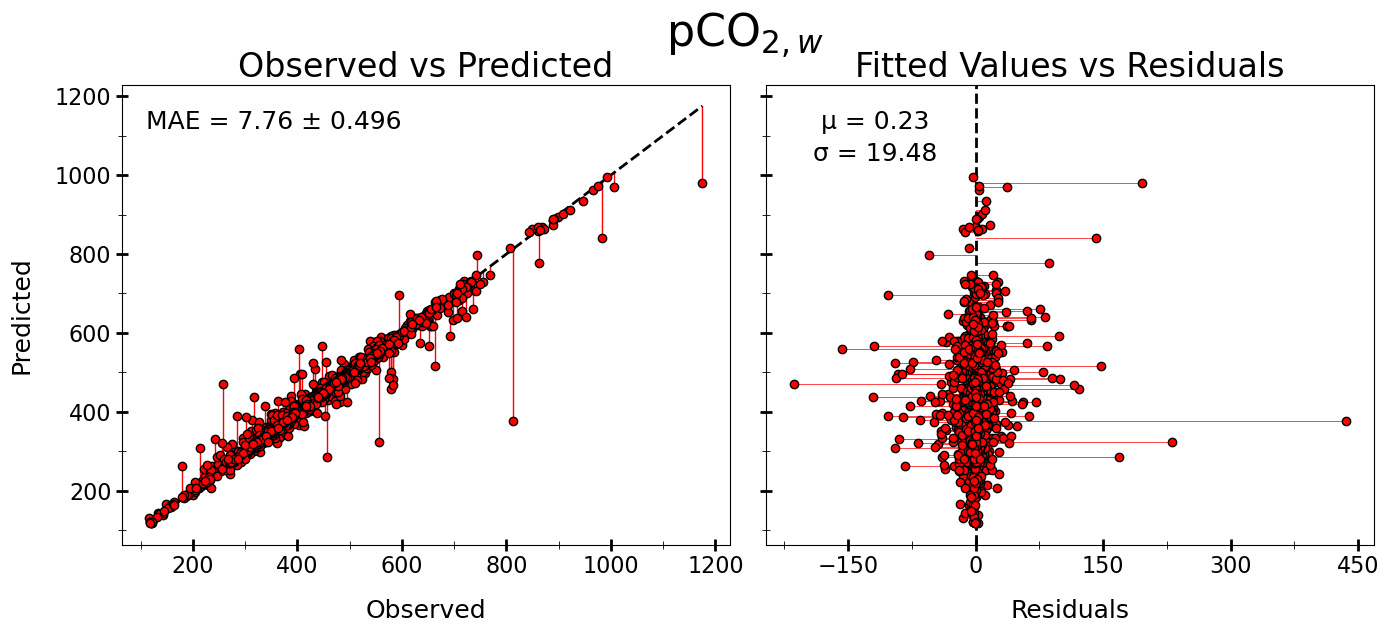

In [10]:
# Plot the Results
fig = plot_model_results(results, 'pCO$_{2,w}$')

fig.savefig('Chomiak_RF_CO2w_model_performance_check.png', dpi = 600, bbox_inches='tight')

In [11]:
# Run the Model to determine feature importance
feature_importances = calculate_permutation_importance(X, y)
print(feature_importances)

   feature  permutation_importance
8   t_adcp                0.791538
0      lat                0.787283
1      lon                0.132124
9    p_rad                0.088185
11    hour                0.079366
10     sog                0.048979
7    t_dew                0.042534
4      lwr                0.042409
6    t_air                0.028010
5       rh                0.014709
3      swr                0.014519
2        u                0.002268


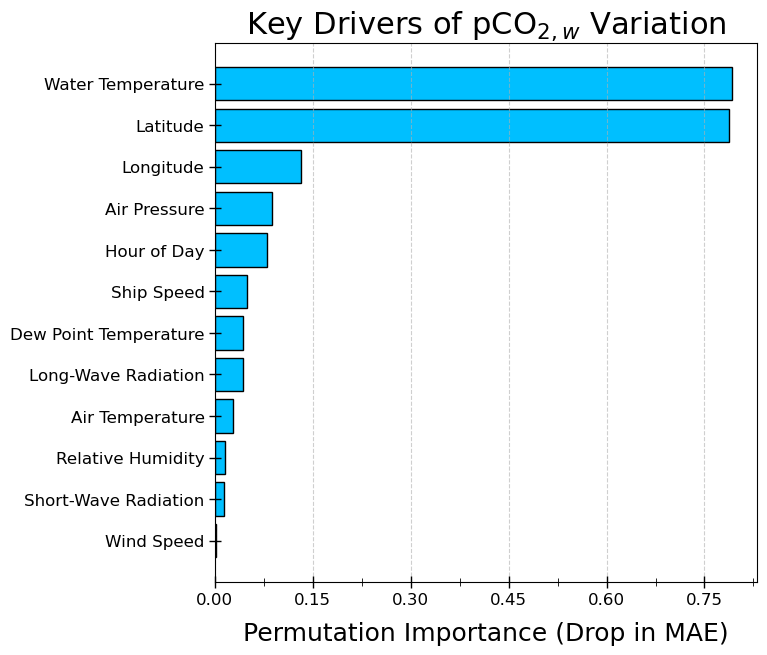

In [12]:
# Create a mapping from feature name to display name
name_map = {
    'lat': 'Latitude', 
    'lon': 'Longitude', 
    'hour': 'Hour of Day', 
    't_adcp': 'Water Temperature', 
    't_air': 'Air Temperature',
    't_dew': 'Dew Point Temperature', 
    'rh': 'Relative Humidity', 
    'p_rad': 'Air Pressure', 
    'swr': 'Short-Wave Radiation', 
    'lwr': 'Long-Wave Radiation',
    'u': 'Wind Speed', 
    'sog': 'Ship Speed', 
}

# Get the display names corresponding to the sorted features
custom_labels = [name_map[feature] for feature in feature_importances['feature']]

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(feature_importances['feature'], feature_importances['permutation_importance'], color='deepskyblue', ec='black')
#ax.set_title('Feature Importance (CO$_{2,w}$)', fontsize=24)
ax.set_title("Key Drivers of pCO$_{2,w}$ Variation", fontsize=22)
ax.set_xlabel(r"Permutation Importance (Drop in MAE)", fontsize=18, labelpad=10)
#ax.set_xlabel("Gini Importance", fontsize=22, labelpad=10)

#ax[1].set_title('$^{13}$CO$_{2,w}$', fontsize=24)
#ax[2].set_title('CH$_{4,w}$', fontsize=24)
#ax[3].set_title('$^{13}$CH$_{4,w}$', fontsize=24)
# Set the custom y-axis labels
ax.set_yticklabels(custom_labels)
# Invert y-axis only once after plotting all subplots
ax.invert_yaxis()
ax.xaxis.set_major_locator(MaxNLocator(6))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=12, width=1.0)
ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.savefig('Chomiak_RF_CO2w_fi_permutation.png', dpi = 600, bbox_inches='tight')

### Quick Analysis:
The Random Forest Model showed good performance. The MAE was 7 on test data, and averaged 7.76 ± 0.50 after a 5-fold cross validation. As a reminder, the MAE represents the average absolute difference between the observed and predicted pCO2 values in surface waters. The mean of residuals, 0.23, is close to zero indicating that there is no systematic bias in the model predictions. The standard deviation of residuals was slightly high.

The analysis of feature importance aligns with our exploratory data analysis (EDA) showing that latitude and water temperature are primary drivers of pCO2 variations in the surface waters of the Yenisey River. The sampling area spans a latitude of 56N to 68N and spans boreal forests and tundra with various soil orders and surface lithology. EDA showed that water temperature increased with latitude, while air temperature decreased. The solubility of CO2 is inversely related to water temperature - Cold water stores more CO2 than warm water. This temperature-dependent factor was displayed in the data. Additionally, warmer temperatures can mediate respiration, which can affect CO2 output. pH was not measured in this study, so chemical equilibrium and DIC speciation cannot be inferred. 